## LangGraph, capture user's input
This script is to capture the user's input and display it. This will demonstrate the Human-In-Loop (HIL) feature of LangGraph.

In [24]:
from typing import TypedDict,List
from langchain.schema import BaseMessage
from typing import Optional

# Define our state structure
class State(TypedDict):
    foo: str
    human_value: Optional[str]

In [25]:
from langgraph.graph import StateGraph, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver # This is required to save the state of the graph between interrupts

# StateGraph
workflow = StateGraph(State)

# Node to ask the question
def ask_human(state: State) -> State:
    uinput = interrupt("What's is your name?")
    print(f"> Received input {uinput}")

    return {"human_value": uinput}


# Lets add our first node to workflow
workflow.add_node("ask_human", ask_human)

# Lets wireup the node with start and end nodes
workflow.add_edge("ask_human", END)    # Connecting the END Node
workflow.set_entry_point("ask_human")  # Pointing the _START_ node

# All done, lets compile the workflow to make an app
cp = MemorySaver()
app = workflow.compile(checkpointer = cp)

Now the workflow is compiled and ready for execution. We can visualize the workflow that we created to identify any mistages.

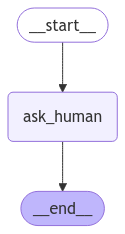

In [8]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

## Run the app/workflow

In [26]:
import uuid

init_state = {"next_step":"", "messages":[]}
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}

cmd = Command(resume="Test message")
for event in app.stream(cmd, config):
    print(event)
                    
print("End of workflow")

InvalidUpdateError: Must write to at least one of ['foo', 'human_value']